## **Попробуйте улучшить базовый вариант ALS, изменяя следующие параметры**

- regularization, iterations
- factors
- Вес (TF_IDF, BM25 взвешивание)
- Посчитайте метрики (Precision@5, MAP@5) для разных наборов гиперпараметров и выберете лучший набор

In [32]:
pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

In [34]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,2.698485e+10,1.0,1004906.0,1.0,1.39,364.0,-0.6,1631.0,1.0,0.0,0.0
1,2375,2.698485e+10,1.0,1033142.0,1.0,0.82,364.0,0.0,1631.0,1.0,0.0,0.0


In [35]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [36]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[829323.0, 835108.0, 836423.0, 851515.0, 87524..."
1,2,"[895388.0, 8357614.0, 12301772.0, 821083.0, 82..."


In [37]:
def precision_at_k(recommended_list, bought_list, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)[:k]
    flags = np.isin(recommended_list, bought_list)

    precision = flags.sum() / len(recommended_list)

    return precision

In [38]:
def apk(recommended_list, bought_list, k=5):

    score = precision_at_k(recommended_list, bought_list, k=k)

    return score / min(len(bought_list), k)

def mapk(recommended_list, bought_list, k=5):

      return np.mean([apk(a,p,k) for a,p in zip(recommended_list, bought_list)])

In [39]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in
                    model.recommend(userid=userid_to_id[user],
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N,
                                    filter_already_liked_items=False,
                                    filter_items=[itemid_to_id[999999]],
                                    recalculate_user=True)[0]]
    return res

In [40]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [41]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train,
                                  index='user_id', columns='item_id',
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count',
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head()

item_id,202291.0,397896.0,420647.0,480014.0,545926.0,707683.0,731106.0,818980.0,819063.0,819255.0,...,15596488.0,15596515.0,15778533.0,15831255.0,15926844.0,15926886.0,15927403.0,15927661.0,15927850.0,16809471.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [43]:
factors = [50, 75, 100, 125, 150]
p5 = []
map5= []

In [44]:
%%time
for val in factors:
    model = AlternatingLeastSquares(factors=val,
                                regularization=0.01,
                                iterations=15,
                                calculate_training_loss=True,
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций
                        filter_already_liked_items=False,
                        filter_items=[itemid_to_id[999999]],
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 20min 19s, sys: 28min 8s, total: 48min 28s
Wall time: 26min 43s


In [45]:
p5

[0.16248012718600954,
 0.15760466348701643,
 0.1589825119236884,
 0.15166931637519873,
 0.144568097509274]

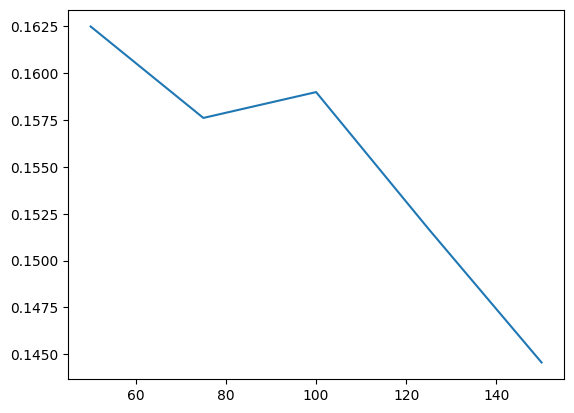

In [46]:
plt.plot(factors, p5[:5])

In [47]:
map5

[0.033732556085497266,
 0.032828122239886945,
 0.0328634516869811,
 0.031589825119236886,
 0.03013071895424837]

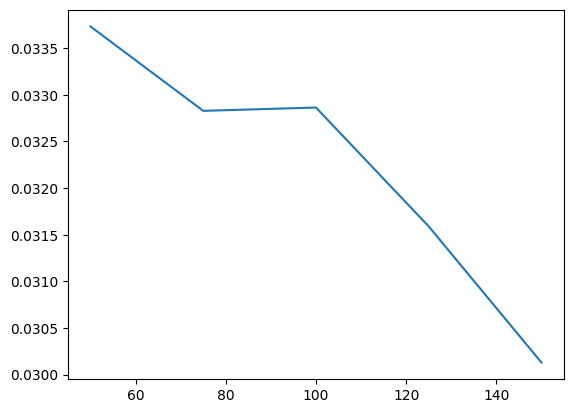

In [48]:
plt.plot(factors, map5[:5])

Как видно из графиков, наилучшие результаты по метрикам получились при параметре factors = 50.

Попробуем поменять величину регуляризации:

In [49]:
reg = [0.001, 0.005, 0.01, 0.05, 0.1]
p5 = []
map5= []

In [50]:
%%time
for val in reg:
    model = AlternatingLeastSquares(factors=75,
                                regularization=val,
                                iterations=15,
                                calculate_training_loss=True,
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций
                        filter_already_liked_items=False,
                        filter_items=[itemid_to_id[999999]],
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 18min 21s, sys: 25min 26s, total: 43min 48s
Wall time: 24min 31s


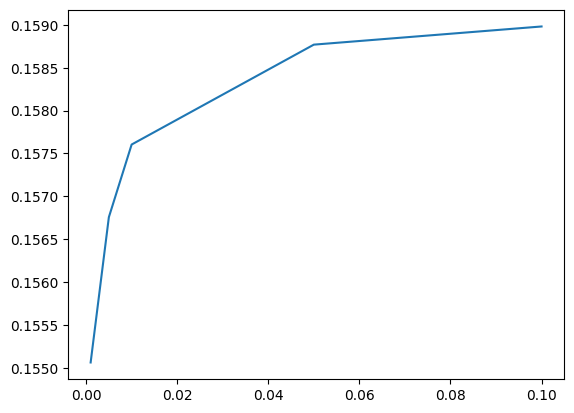

In [51]:
plt.plot(reg, p5)

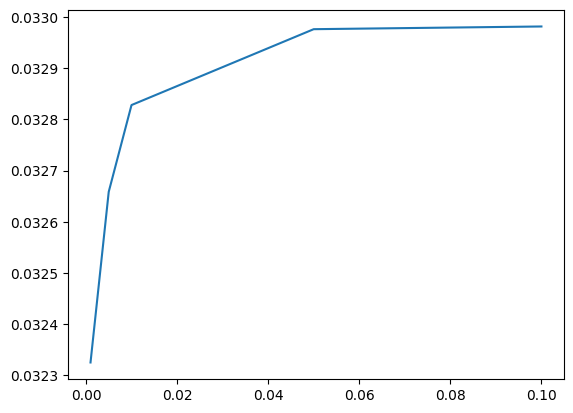

In [52]:
plt.plot(reg, map5)

Наилучшие результаты получились при регуляризации = 0.1

Проделаем то же самое для количества итераций:

In [53]:
iterations = [5, 10, 15, 20, 25]
p5 = []
map5= []

In [54]:
%%time
for val in iterations:
    model = AlternatingLeastSquares(factors=75,
                                regularization=0.1,
                                iterations=val,
                                calculate_training_loss=True,
                                num_threads=4,random_state=42)

    model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

    recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций
                        filter_already_liked_items=False,
                        filter_items=[itemid_to_id[999999]],
                        recalculate_user=False)
    result['als'] = result['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))
    p5.append(result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean())
    map5.append(result.apply(lambda row: apk(row['als'], row['actual']), axis=1).mean())

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: user 21min 35s, sys: 30min, total: 51min 36s
Wall time: 28min 25s


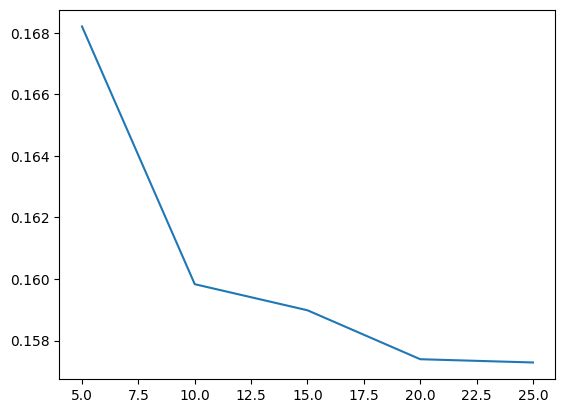

In [55]:
plt.plot(iterations, p5)

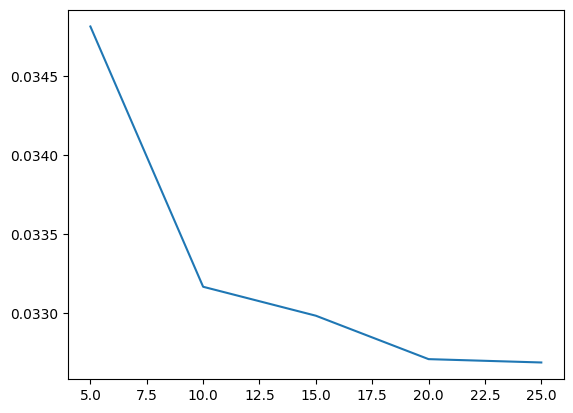

In [56]:
plt.plot(iterations, map5)

При 5 итерациях алгоритм выдает наилучший результат.
